# Import modules

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
for folder in ('dss_tools', 'dss_grid_examples', 'Environment', 'Grids', 'Markets', 'Agents', 'utils'):
    
    if folder not in sys.path:
        sys.path.insert(0, folder)

In [3]:
from opendss_tools import DSS, DSS_from_docstring, DSS_from_empty

from Environment import Environment
from DoNothingAgent import DoNothingAgent
from DoNothingMarket import DoNothingMarket
from DoNothingGrid import DoNothingGrid

# Test DSS interface with IEEE 34 bus

In [4]:
dss_path = r'dss_grid_examples\34Bus\ieee34Mod1.dss'
xy_path = r'dss_grid_examples\34Bus\IEEE34_BusXY.csv'

dss = DSS.open_case_from_file(dss_path)

dss.command(f"BusCoords [{xy_path}]")

dss.summarize()

37 Buses
95 Nodes
Voltage Bases (kV L-L):	 69.0, 24.9, 4.16, 0.48
Circuit Elements:
		1 Vsource
		8 Transformers
		32 Lines
		2 Capacitors
		6 RegControls
		68 Loads


In [5]:
dss.get_bus_df().head()

,x,y,VmagPu
sourcebus,-300.0,0.0,1.049996
800,0.0,0.0,1.049994
802,400.0,0.0,1.048111
806,700.0,0.0,1.046870
808,1000.0,0.0,1.024143


# DoNothing

In [6]:
grid = DoNothingGrid()

market = DoNothingMarket()

agents = [DoNothingAgent(), DoNothingAgent(), DoNothingAgent()]

env = Environment(grid=grid, market=market, agents=agents)

In [7]:
env.reset()
for t in env.iterate(5):
    pass

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 5009.92it/s]


# Demo Grid only

In this demo, the grid randomly fluctuates load consumption and records bus voltages at each step.

In [8]:
from BaseGrid import BaseGrid

class DemoGrid(BaseGrid):
    def __init__(self, dss_path, xy_path=None, load_std=0.2):
        self.dss_path = dss_path
        self.xy_path = xy_path
        
        self.load_std = load_std
        
        self.reset()
        
    def reset(self):
        self.dss = DSS.open_case_from_file(self.dss_path)
        if self.xy_path is not None:
            self.dss.command(f"BusCoords [{self.xy_path}]")
        
        self.t = -1
        self.voltages = []
    
    def step(self):
        self.randomly_fluctuate_loads()
        self.dss.solve_case()
        self.record_voltages()
        
    def randomly_fluctuate_loads(self):
        for load in self.dss.Circuit.Loads:
            load.kW *= 1 + self.load_std * np.random.randn()
            
    def record_voltages(self):
        v = self.dss.get_bus_df().VmagPu.values
        self.voltages.append(v)
        
    def plot_voltages(self, *plot_args, **plot_kwargs):
        plt.plot(self.voltages, *plot_args, **plot_kwargs)
        xlim = plt.xlim(0, self.t)
        plt.hlines(1.0, *xlim, color='r')
        plt.hlines([0.95, 1.05], *xlim, color='r', linestyle='--')
        
grid = DemoGrid(dss_path, xy_path)

In [9]:
env = Environment(grid=grid, market=market, agents=agents)

env.reset()
for t in env.iterate():
    pass

100%|████████████████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 1007.37it/s]


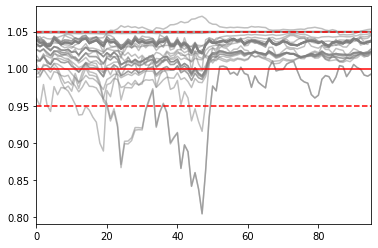

In [10]:
env.grid.plot_voltages(color='gray', alpha=0.5)

# Demo Grid & Agent

In this demo, the agent responds to local voltages by incrementing/decrementing load

In [11]:
from BaseAgent import BaseAgent

class DemoAgentVoltageControl(BaseAgent):

    def __init__(self, load=None, bus=None):
        if load is None or bus is None:
            raise ValueError('load and bus must be str, not None.')
        
        self.load = load
        self.bus = bus
        self.voltages = []
        
    def get_voltage(self):
        return self.env.grid.dss.get_bus_df().loc[self.bus, 'VmagPu']
    
    def get_load(self):
        load_df = self.env.grid.dss.get_load_df().loc[self.load]
        kW, kvar = load_df.kW, load_df.kvar
        return kW, kvar
    
    def increment_load(self, delta_kW=0.0, delta_kvar=0.0):
        kW, kvar = self.get_load()
        
        new_kW = kW + delta_kW
        new_kvar = kvar + delta_kvar
        
        self.env.grid.dss.edit(f'Load.{self.load}', kW=new_kW, kvar=new_kvar)
    
    def set_market_actions(self):
        pass
    
    def set_grid_actions(self):
        
        # Simple feedback control
        v = self.get_voltage()
        self.voltages.append(v)
        delta_kW = 3 * (1 - v) / 0.05
        delta_kvar = 1 * (1 - v) / 0.05
        
        # Update load
        self.increment_load(delta_kW=delta_kW, delta_kvar=delta_kvar)
        
agent_grid = DemoAgentVoltageControl(load='s890', bus='890')

In [12]:
agents = [agent_grid]
grid = DemoGrid(dss_path, xy_path, load_std=0.01)

env = Environment(grid=grid, market=market, agents=agents)

env.reset()
for t in env.iterate():
    pass

100%|█████████████████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 311.51it/s]


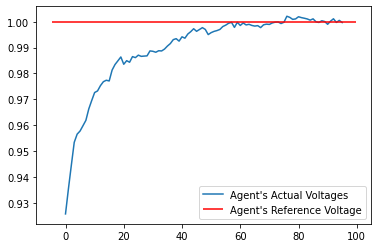

In [13]:
plt.plot(agent_grid.voltages, label="Agent's Actual Voltages")
plt.hlines(1.0, *plt.xlim(), color='r', label="Agent's Reference Voltage")
plt.legend();

# Demo Grid & Market & Agents

In this demo, we assume the distribution market is faced with a new (incremental) demand at the beginning of each market clearning process. Its job is to dispatch all supply units with how much to supply and how much to get paid.

For simplicity, we assume that the source bus (feeder) in the distribution grid provides an electricity price (1.0 for reference) which is exogenously determined (for example, by a transmission grid market).

Then, we let an agent represent a load that is willing to sacrifice some consumption (acting like a reserve) and receive a reward for it. If the price accepted is lower than that of the source bus, the market will adjust dispatch accordingly.

In [14]:
from BaseMarket import BaseMarket

class DemoMarket(BaseMarket):
    def __init__(self, max_steps=1):
        self.max_steps = max_steps
        self.reset()

    def reset(self):
        self.t = -1
        self.new_demand = 100
        
        self.source_price = 1.0
        self.source_dispatch = self.new_demand * 1.0
        
        # To be changed by agent
        self.agent_price = 999 # large to represent inelastic
        self.agent_capacity = 0.0
        self.agent_dispatch = 0.0

    def step(self):
        if self.agent_capacity > 0.0 and self.agent_price < self.source_price:
            self.agent_dispatch = np.minimum(self.agent_capacity, self.new_demand)
        else:
            self.agent_dispatch = 0.0
            
        self.source_dispatch = self.new_demand - self.agent_dispatch
            
market = DemoMarket()

In [15]:
class DemoAgentReserveSupply(BaseAgent):

    def __init__(self, load=None, minimum_kW=0.0):
        if load is None:
            raise ValueError('load must be str, not None.')
        
        self.load = load
        self.minimum_kW = minimum_kW
        
        self.dispatches = []
        self.kWs = []
    
    def set_market_actions(self):
        kW = self.get_load()
        
        # Do not be willing to sacrifice too much
        if kW < self.minimum_kW:
            self.env.market.agent_capacity = 0.0
        else:
            self.env.market.agent_capacity = kW - self.minimum_kW
        
        # Random offer
        self.env.market.agent_price = 1.1 + 0.2 * np.random.randn()
    
    def get_load(self):
        kW = self.env.grid.dss.get_load_df().loc[self.load, 'kW']
        return kW
    
    def increment_load(self, delta_kW=0.0):
        kW = self.get_load()
        
        new_kW = kW + delta_kW
        
        self.env.grid.dss.edit(f'Load.{self.load}', kW=new_kW)
    
    def set_grid_actions(self):
        kW_drop = self.env.market.agent_dispatch
        
        self.increment_load(kW_drop)
        
        self.dispatches.append(kW_drop)
        self.kWs.append(self.get_load())
    
agent_market = DemoAgentReserveSupply(load='s844', minimum_kW=1300)

In [16]:
agents = [agent_grid, agent_market]

grid = DemoGrid(dss_path, xy_path, load_std=0.01)

market = DemoMarket()

env = Environment(grid=grid, market=market, agents=agents)

env.reset()
for t in env.iterate():
    pass

100%|█████████████████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 130.07it/s]


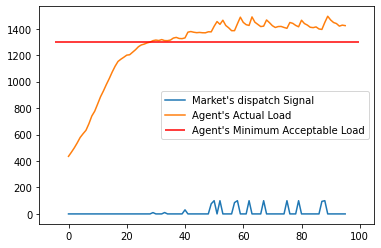

In [17]:
plt.plot(agent_market.dispatches, label="Market's dispatch Signal")
plt.plot(agent_market.kWs, label="Agent's Actual Load")
plt.hlines(agent_market.minimum_kW, *plt.xlim(), color='r', label="Agent's Minimum Acceptable Load")
plt.legend();